# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Shooting Star

In the previous video units, we saw the formation of a Shooting Star. It is formed during an uptrend and signals a possible reversal of the existing uptrend. Hence, we can initiate a short trade after formation of a shooting star. This is how a shooting star looks like:

![title](https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/9U1l9Vw3/shootingstar.png)

The strategy will be to enter the short trade on the next candle after formation of a shooting star and exit the trade when either stop-loss or take-profit gets hit.

In this notebook, we will generate signals for shooting star, visualise the shooting star pattern, backtest the above trading strategy and analyse the strategy performance.

The notebook is structured as follows:
1. [Import the Data](#import)
2. [Identify Shooting Star](#identify)
3. [Plot Shooting Star Pattern](#plotpattern)
4. [Entry Condition](#entry)
5. [Exit Condition](#exit)
6. [Backtesting and Strategy Performance](#backtesting_and_performance)

## Import Libraries

We will use `candlestick_quantra_utility` which is a custom module and contains functions for backtesting, trade-level analytics and analysis of strategy's performance.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For technical indicators
import talib as ta

# For backtesting and strategy performance
import sys
sys.path.append('..')
from data_modules.candlestick_quantra_utility import backtesting, trade_level_analytics, performance_metrics

# For plotting
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

<a id='import'></a>
## Import the Data

Import the file `AAPL_15min_2017_2021.csv` using the `read_csv` method of `pandas`. This file has the 15-minute OHLC values for Apple stock. 
This CSV file is available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section.

In [2]:
# Import price data of Apple stock
data = pd.read_csv('../data_modules/AAPL_15min_2017_2021.csv', index_col=0)

# Change index to datetime
data.index = pd.to_datetime(data.index)

# Display the data
data.tail()

,Open,High,Low,Close
2021-02-11 14:45:00+00:00,134.270,134.340,133.66,134.339
2021-02-11 15:00:00+00:00,134.340,134.710,134.24,134.610
2021-02-11 15:15:00+00:00,134.605,135.272,134.40,134.750
2021-02-11 15:30:00+00:00,134.755,134.920,134.36,134.680
2021-02-11 15:45:00+00:00,134.675,135.280,134.66,135.120


<a id='identify'></a>
## Identify Shooting Star

We will identify the shooting star pattern. For the pattern identification, we will use the `talib` library function `CDLSHOOTINGSTAR`.

Syntax:
```python
ta.CDLSHOOTINGSTAR(data['Open'], data['High'], data['Low'], data['Close'])
```
This function takes `Open`, `High`, `Low` and `Close` values as input and returns an integer value as output. 

An integer value of `-100` is generated when there is a shooting star formation, else the function returns 0.

In [3]:
# Generate signal for Shooting Star
data['pattern_signal'] = ta.CDLSHOOTINGSTAR(data['Open'], data['High'], data['Low'], data['Close'])

<a id='plotpattern'></a>
## Plot Shooting Star Pattern

We will plot the shooting star pattern on the candlestick chart.

<img align="left" width="30" height="30" src="https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/dMbD1sub/blackmarker.png"> --  To easily identify the shooting star pattern we will use this black marker which will basically indicate a shooting star formation.  

We will store the marker position in an array `ss_marker` and plot the marker at a height of `0.1%` above the `High` price so that it is clearly visible on the chart. We will take only the last `50` values for plotting so as to avoid clutter on the chart. 

We have used the `make_addplot` function from the `mplfinance` library to plot the shooting star pattern. You can know more about the `make_addplot` function <a href='https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb' target="_blank">here</a>.

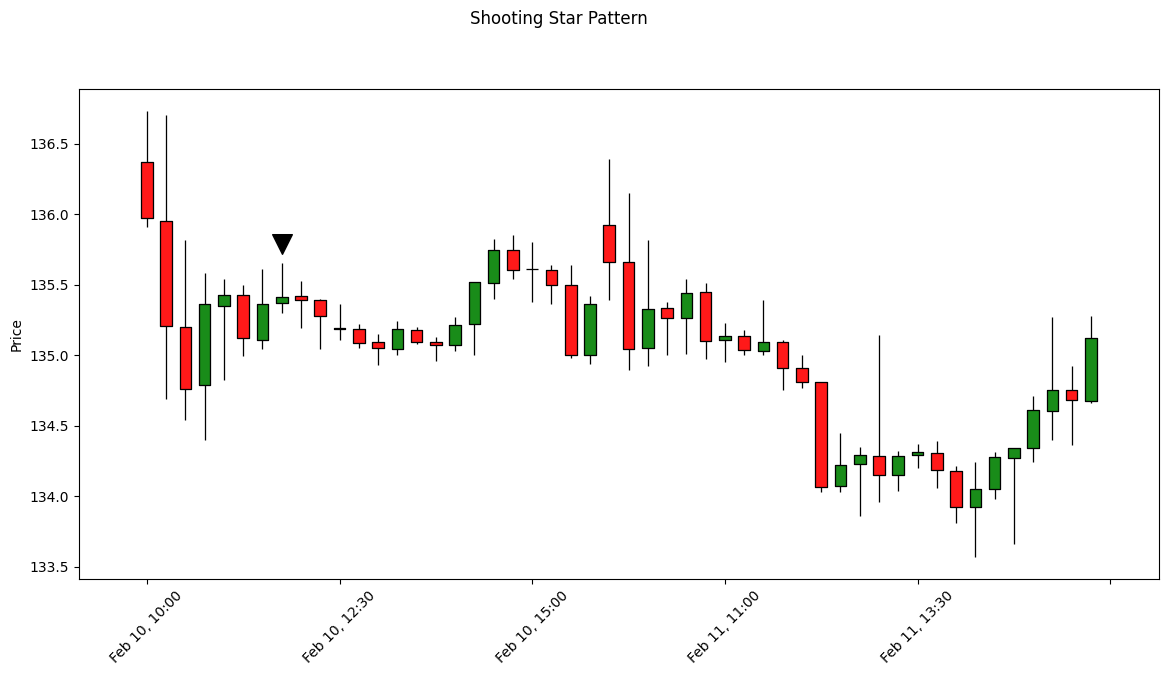

In [4]:
# Set pattern occurrence positions
ss_marker = np.where(data.tail(50).pattern_signal == -100, (1.001 * data.tail(50).High), np.nan)

# Plot shooting star pattern
ss_plot = mpf.make_addplot(ss_marker, type='scatter', marker='v', markersize=200, panel=0, color="black")
mpf.plot(data.tail(50), type='candle', style=mpf.make_mpf_style(marketcolors=mpf.make_marketcolors(up='g',down='r')), 
         addplot=ss_plot, title='Shooting Star Pattern', figsize=(15, 7))

We found one shooting star on `Feb 10`.

<a id='entry'></a>
## Entry Condition

We will check the conditions for entering the trade, set the `entry_signal` as `-1` when `pattern_signal` is -100 . `-1` indicates that we will initiate a short position. 

Entry: We will enter the trade at the `Open` of the current candle if the previous candle is a shooting star and there is an existing uptrend. We will check for the uptrend by checking the `Close` prices of the previous 3 candles. If the `Close` prices of the last 3 candles are in descending order, i.e. if the `Close` price of the candle just previous to the shooting star is greater than its previous candle and so on then it can be considered as an uptrend.

In [5]:
# Check if pattern is formed
condition_1 = (data['pattern_signal'] == -100)

# Check if there is a downtrend
condition_2 = data.Close.shift(1) > data.Close.shift(2)
condition_3 = data.Close.shift(2) > data.Close.shift(3)
condition_4 = data.Close.shift(3) > data.Close.shift(4)

# Generate entry signal
data['entry_signal'] = np.where(condition_1 & condition_2 & condition_3 & condition_4, -1, 0)

<a id='exit'></a>
## Exit Condition

Stop-loss: The stop-loss will be kept at the `High` price of the shooting star candle. In the below example, the entry price is 50 and the `High` price of the shooting star candle is 70, so we will keep the stop-loss at 70.

Take-profit: We will book the profit if the price moves down by the difference between stop-loss and entry price. In the below example, as the difference between the entry price and stop-loss is 20 points so we will keep the take-profit at 30.

![title](https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/tadbBOYK/shootingstarentryexit.png)

The stop-loss and take-profit will be calculated using `exit_values` function which has been explained in detail in the previous notebooks.

<a id='backtesting_and_performance'></a>
## Backtesting and Strategy Performance

We will use the `backtesting` function from `candlestick_quantra_utility` to backtest our trading strategy. It takes dataframe `data`, trade direction which can be `long` or `short`, `rr` which is basically reward to risk ratio as inputs, backtests the trading strategy and returns `trades` which is basically the trade sheet, and dataframe `data` which contains the trading signals.

For checking the strategy performance we will use two functions, `trade_level_analytics` for calculating trade level analytics and `performance_metrics` for checking the strategy performance. The codes for these functions have been taken directly from the previous notebooks.

In [6]:
# Backtest the strategy and generate trade sheet
data, trades = backtesting(data, direction = "short", rr = 1)
trades.tail()

------------------------------
Trade No: 1 | Entry Date: 2017-01-04 10:00:00+00:00 | Entry Price: 29.07
Trade No: 1 | Exit Type: TP | Date: 2017-01-04 10:30:00+00:00 | Exit Price: 28.9975 | PnL: 0.07 | Cum PnL: 0.07
------------------------------
Trade No: 2 | Entry Date: 2017-03-07 10:45:00+00:00 | Entry Price: 34.9625
Trade No: 2 | Exit Type: TP | Date: 2017-03-07 11:00:00+00:00 | Exit Price: 34.92 | PnL: 0.04 | Cum PnL: 0.11
------------------------------
Trade No: 3 | Entry Date: 2017-03-22 11:45:00+00:00 | Entry Price: 35.34
Trade No: 3 | Exit Type: TP | Date: 2017-03-22 12:00:00+00:00 | Exit Price: 35.2275 | PnL: 0.11 | Cum PnL: 0.22
------------------------------
Trade No: 4 | Entry Date: 2017-07-10 13:15:00+00:00 | Entry Price: 36.3975
Trade No: 4 | Exit Type: SL | Date: 2017-07-10 13:45:00+00:00 | Exit Price: 36.4675 | PnL: -0.07 | Cum PnL: 0.15
------------------------------
Trade No: 5 | Entry Date: 2017-12-11 12:45:00+00:00 | Entry Price: 43.135
Trade No: 5 | Exit Type: TP 

,Entry_Date,Entry_Price,Exit_Date,Exit_Type,Exit_Price,PnL
42,2020-06-16 12:00:00+00:00,87.6000,2020-06-16 12:30:00+00:00,SL,87.925,-0.33
43,2020-07-09 12:30:00+00:00,95.5975,2020-07-09 13:00:00+00:00,SL,95.825,-0.23
44,2020-10-13 15:30:00+00:00,121.8000,2020-10-13 15:45:00+00:00,TP,121.060,0.74
45,2020-12-08 11:45:00+00:00,123.6400,2020-12-08 12:00:00+00:00,SL,124.035,-0.39
46,2021-01-11 12:45:00+00:00,129.8500,2021-01-11 13:15:00+00:00,TP,129.610,0.24


In [7]:
# Trade Level Analytics
analytics = trade_level_analytics(trades)
analytics.T

Total PnL:  -2.75


,Strategy
Total PnL,-2.75
total_trades,47
Number of Winners,17
Number of Losers,30
Win (%),36.170213
Loss (%),63.829787
per_trade_PnL_winners,0.218235
per_trade_PnL_losers,0.215333
Average holding time,0 days 05:05:44.680851063
Profit Factor,0.574303


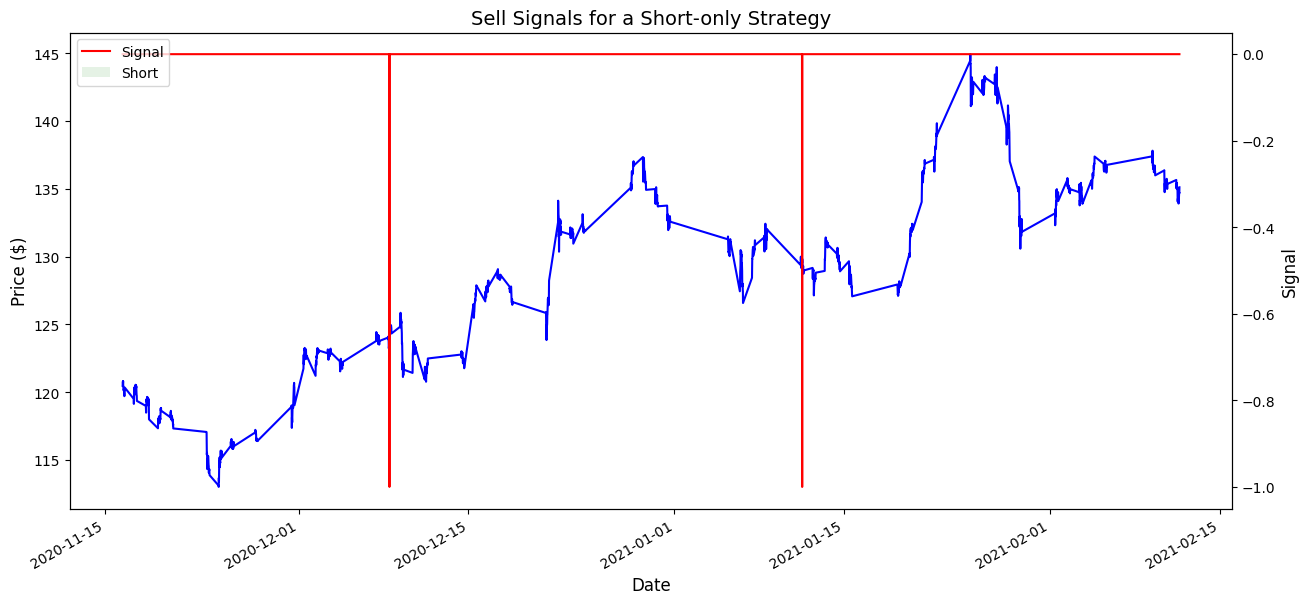

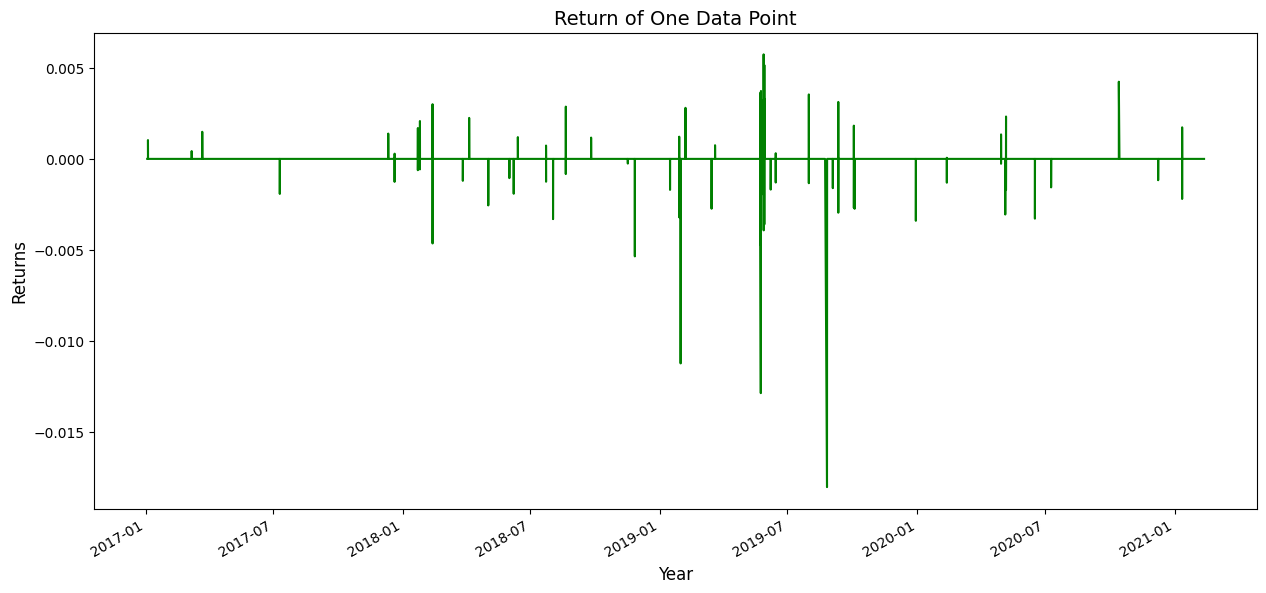

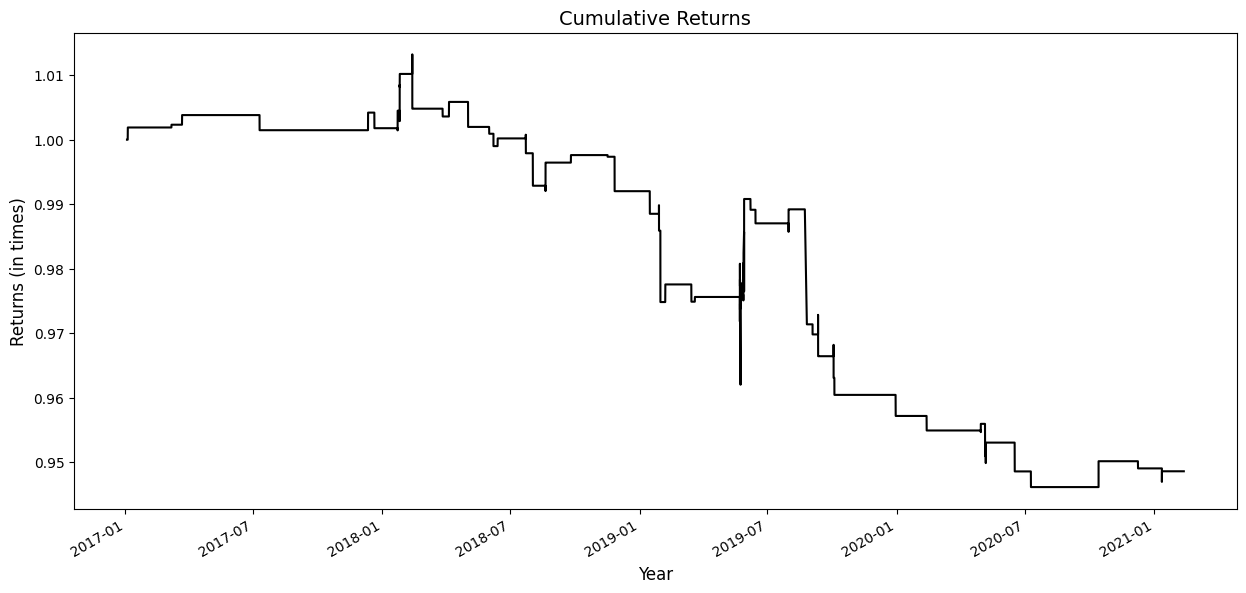

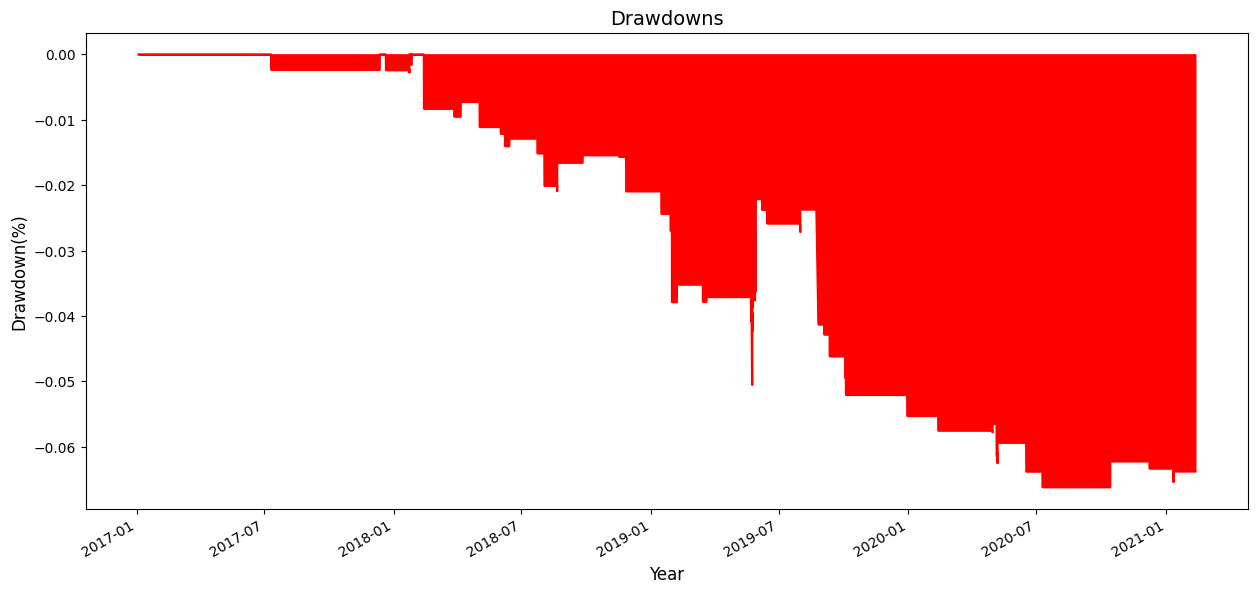

,Strategy
Sharpe Ratio,-1.824931
Maximum Drawdown,-6.62%


In [8]:
# Performance metrics
performance_metrics = performance_metrics(data, direction = "short")
performance_metrics.T

## Conclusion

In this notebook, we saw how we can trade a shooting star pattern with a defined stop-loss and take-profit level. We also analysed the performance of our trading strategy so as to get a deeper idea about the strategy performance. You can also try to backtest a trading strategy for shooting star patterns with different sets of entry and exit conditions. 

In the next section, we will look at another candlestick pattern, a Doji pattern.<br><br><br><br>